# Проект The broken machine
Источник данных - https://www.kaggle.com/ivanloginov/the-broken-machine

Автор: Потапов Даниил (Slack: @sharthZ23)

## Постановка задачи
В данном проекте ставится задача прогнозирования поломки оборудования при помощи его индикаторов, их здесь почти 60 и все они безымянные. Данная задача - это пример использования алгоритмов машинного обучения в системах обнаружения неполадок. Область применения широка: заводское производство, спутники или другие автономные объекты и так далее. Причем тут надо рассмотреть 2 варианта решений: одно направленное на интерпретируемость, а другое на точность.

## 1. Описание набора данных и признаков

Датасет содержит 900000 объектов, каждый из которых содержит 59 признаков, в том числе 1 целевой (он находится в `ytrain.csv`, столбец `x`).
Как я уже сказал выше, признаки полностью анонимные, единственное, что их объединяет, это то, что они все `float64`.

Целевой признак - индикатор того, сломана ли машина (1 - да, 0 - нет).

## 2-3. Первичный анализ данных и первичный визуальный анализ данных

Импортируем нужные библиотеки

In [23]:
import os
import time
import pandas as pd
import numpy as np

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn_pandas import DataFrameMapper
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.discrete.discrete_model as sm
from scipy import stats

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

Укажем пути до данных и загрузим их

In [2]:
DATA_PATH = '/data/kaggle/broken_machine'
X_PATH = os.path.join(DATA_PATH, 'xtrain.csv')
Y_PATH = os.path.join(DATA_PATH, 'ytrain.csv')

In [3]:
X = pd.read_csv(X_PATH)
y = pd.read_csv(Y_PATH)['x']

In [4]:
print(X.shape, y.shape)

(900000, 58) (900000,)


Увеличим максимальное кол-во отображаемых столбцов в `pandas` до 58

In [5]:
pd.set_option('display.max_columns', 100)

Посмотрим на информацию о нашем датасете

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 58 columns):
1     820529 non-null float64
2     808921 non-null float64
3     831550 non-null float64
4     828051 non-null float64
5     819375 non-null float64
6     796632 non-null float64
7     791582 non-null float64
8     796405 non-null float64
9     840044 non-null float64
10    794046 non-null float64
11    792089 non-null float64
12    822082 non-null float64
13    801824 non-null float64
14    822891 non-null float64
15    785297 non-null float64
16    822112 non-null float64
17    804309 non-null float64
18    807722 non-null float64
19    857586 non-null float64
20    829599 non-null float64
21    803971 non-null float64
22    813872 non-null float64
23    768612 non-null float64
24    823381 non-null float64
25    809400 non-null float64
26    823554 non-null float64
27    792591 non-null float64
28    812095 non-null float64
29    786992 non-null float64
30    821643 non-nu

Видно, что все параметры - числа с плавающей точкой и что около 1/9 части каждого параметра отсутствует.
Посмотрим на сами данные.

In [7]:
X.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,-42.822536,NaN,12.0,NaN,1.0,2.0,24.0,-45.025510,NaN,1.0,3.910841,20.037239,NaN,-86.651101,17.0,-11.405955,15.0,4.0,-20.011925,27.271964,1.0,6.0,NaN,6.0,-30.662868,14.0,12.0,42.059872,1.0,2.0,5.0,3.0,1.242426,83.114610,-52.682517,6.0,1.397560,13.858564,5.010444,-1.035085,3.828019,-0.031808,28.884589,1.0,12.0,-41.656958,0.0,4.0,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346
1,-13.478816,13.0,12.0,75.132502,0.0,2.0,24.0,-49.213545,7.0,0.0,103.028552,-44.603587,-75.457614,-109.772769,16.0,-7.386768,18.0,3.0,-52.541216,-23.053329,NaN,4.0,2.0,6.0,22.561123,14.0,11.0,63.131398,5.0,0.0,5.0,5.0,22.215217,110.620332,-40.950731,4.0,0.846452,3.514293,4.839021,-39.124343,-69.000123,6.253618,24.671585,0.0,10.0,-55.085782,NaN,5.0,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489
2,51.702721,13.0,12.0,63.459270,0.0,3.0,24.0,-58.777043,8.0,0.0,14.850524,53.516062,107.018098,-118.540065,17.0,-15.714059,17.0,3.0,27.369359,10.830127,NaN,1.0,2.0,5.0,6.025768,16.0,16.0,50.964614,3.0,1.0,3.0,3.0,19.954300,106.354195,NaN,5.0,1.574550,105.726958,19.599097,-3.289164,37.006898,7.935197,30.661709,2.0,12.0,-36.352728,1.0,NaN,NaN,3.0,16.0,21.851623,NaN,7.471764,-12.348314,34.406243,34.479515,-33.326172
3,NaN,12.0,13.0,-15.492561,1.0,1.0,23.0,0.624258,9.0,0.0,60.256580,32.640212,17.508750,-62.551522,NaN,-3.518383,20.0,3.0,-36.065397,-20.201555,6.0,7.0,0.0,NaN,2.248286,NaN,15.0,49.726230,4.0,1.0,3.0,3.0,6.221229,156.324453,NaN,4.0,2.032347,87.030045,3.688423,-29.169872,-107.670733,1.650324,32.429857,0.0,NaN,-83.484587,1.0,5.0,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956
4,7.633273,NaN,13.0,59.862681,0.0,3.0,NaN,-61.395319,NaN,0.0,62.568909,14.070520,68.503324,-109.179454,17.0,-12.600967,18.0,1.0,27.338942,8.290927,6.0,4.0,3.0,7.0,14.059204,13.0,10.0,55.275521,3.0,0.0,1.0,6.0,13.406162,35.263210,-39.812185,4.0,1.571146,64.538871,NaN,-19.693179,-73.401922,8.437617,28.678940,1.0,10.0,-67.043181,0.0,4.0,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245


У же на первых 5 строчках видно, что с NaN'ми придется что-то делать. Попробуем просто их удалить.

In [8]:
print('Initial size: {}'.format(X.shape))
print('After NaN omit size: {}'.format(X.dropna().shape))

Initial size: (900000, 58)
After NaN omit size: (2462, 58)


Ой, мы потеряли 99% данных. Не получилось и ладно, вспомним о них на стадии feature engineering, а пока посмотрим на первичные числовые признаки каждого параметра.

In [9]:
X.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
count,820529.000000,808921.000000,831550.000000,828051.000000,819375.000000,796632.000000,791582.000000,796405.000000,840044.000000,794046.000000,792089.000000,822082.000000,801824.000000,822891.000000,785297.000000,822112.000000,804309.000000,807722.000000,857586.000000,829599.000000,803971.000000,813872.000000,768612.000000,823381.000000,809400.000000,823554.000000,792591.000000,812095.000000,786992.000000,821643.000000,827947.000000,820935.000000,815735.000000,815943.000000,800966.000000,815103.000000,831796.000000,816783.000000,812253.000000,786253.000000,832848.000000,844694.000000,820059.000000,794462.000000,806247.000000,820501.000000,813624.000000,807994.000000,803958.000000,836761.000000,798606.000000,843544.000000,814017.000000,812818.000000,800856.000000,812926.000000,835366.000000,786115.000000
mean,11.012513,12.329729,11.344055,25.406132,0.313465,2.180648,23.222268,-46.304667,7.901558,0.269151,18.861322,-0.041151,34.218568,-75.809123,17.017246,-10.157221,16.487517,3.262584,-12.330677,-0.459010,3.996705,4.528458,1.943161,5.242677,-4.216974,13.804168,12.944043,51.502419,3.087400,0.480919,3.703203,3.679392,12.461969,94.034313,-40.156848,3.568553,13.057739,58.122214,-6.123216,-16.370387,-16.136563,1.004033,33.459364,0.873484,10.854306,-22.304327,0.180856,4.151400,20.596154,2.982181,14.680950,24.042950,-19.295371,16.461962,-25.783931,26.158484,38.320750,-37.013222
std,99.986889,0.796650,1.662548,20.636810,0.536960,0.771303,0.867651,19.875120,1.286734,0.443519,49.614572,57.759273,48.851803,36.291627,1.593982,7.029631,1.702498,1.563738,47.748428,16.883979,2.000666,1.679393,0.827062,1.903169,30.479622,2.067500,2.376194,8.740448,1.592139,0.658498,0.980956,1.474963,9.489320,33.014736,26.893601,1.662087,703.427308,47.026958,14.919673,18.117609,49.942193,3.000944,9.100382,0.787409,1.018797,35.154747,0.384899,1.679597,6.409154,1.097207,2.301128,29.146244,47.647342,45.131263,23.565330,8.508795,5.995944,15.246010
min,-480.088690,7.000000,3.000000,-72.310070,0.000000,0.000000,17.000000,-138.181159,1.000000,0.000000,-209.150651,-99.999949,-189.175571,-249.445847,8.000000,-42.982325,7.000000,0.000000,-269.369596,-83.560468,0.000000,0.000000,0.000000,0.000000,-146.801871,3.000000,2.000000,8.707719,0.000000,0.000000,0.000000,0.000000,-33.598865,-72.840032,-169.554805,0.000000,0.001055,-182.790369,-77.903990,-107.536168,-242.543540,-13.849135,-9.012487,0.000000,4.000000,-201.520935,0.000000,0.000000,-11.358178,0.000000,4.000000,-115.421307,-246.217734,-197.419313,-136.146509,-14.899675,9.648201,-112.352665
25%,-56.357813,12.000000,10.000000,11.492726,0.000000,2.000000,23.000000,-59.736287,7.000000,0.000000,-14.634677,-50.112412,1.308361,-100.329038,16.000000,-14.901519,15.000000,2.000000,-44.549383,-11.861807,3.000000,3.000000,1.000000,4.000000,-24.785978,12.000000,11.000000,45.605898,2.000000,0.000000,3.000000,3.000000,6.067196,71.757228,-58.322774,2.000000,0.539710,26.477823,-16.203234,-28.605769,-49.831652,-1.017484,27.318588,0.000000,10.000000,-46.089043,0.000000,3.000000,16.278806,2.000000,13.000000,4.395491,-51.462848,-13.974363,-41.718505,20.427519,34.264541,-47.312376
50%,11.029669,13.000000,11.000000,25.421574,0.000000,2.000000,23.000000,-46.305721,8.000000,0.000000,18.794859,-0.066081,34.142487,-75.824085,17.000000,-10.154716,17.000000,3.000000,-12.304059,-0.451381,4.000000,4.000000,2.000000,5.000000,-4.201808,14.000000,13.000000,51.499438,3.000000,0.000000,4.000000,4.000000,12.453091,94.100997,-40.148911,3.000000,1.251148,58.133416,-6.130804,-16.371175,-16.128463,1.010162,33.467780,1.000000,11.000000,-22.276223,0.000000,4.000000,20.605346,3.000000,15.000000,24.050412,-19.318562,16.460499,-25.779677,26.149082,38.316862,-36.990170
75%,78.379658,13.000000,13.000000,39.346755,1.000000,3.000000,24.000000,-32.910540,9.000000,1.000000,52.360987,49.931081,67.202304,-51

Сразу бросается в глаза, что все параметры можно разделить на 2 части: те у кого (`min`, `N%`, `max`) не содержат числа после запятой (отличные от 0) и наоборот.
Это говорит о том, что у некоторых параметров мало уникальных значений и они, возможно, больше категориальные, чем числовые. Проверим эту гипотезу.

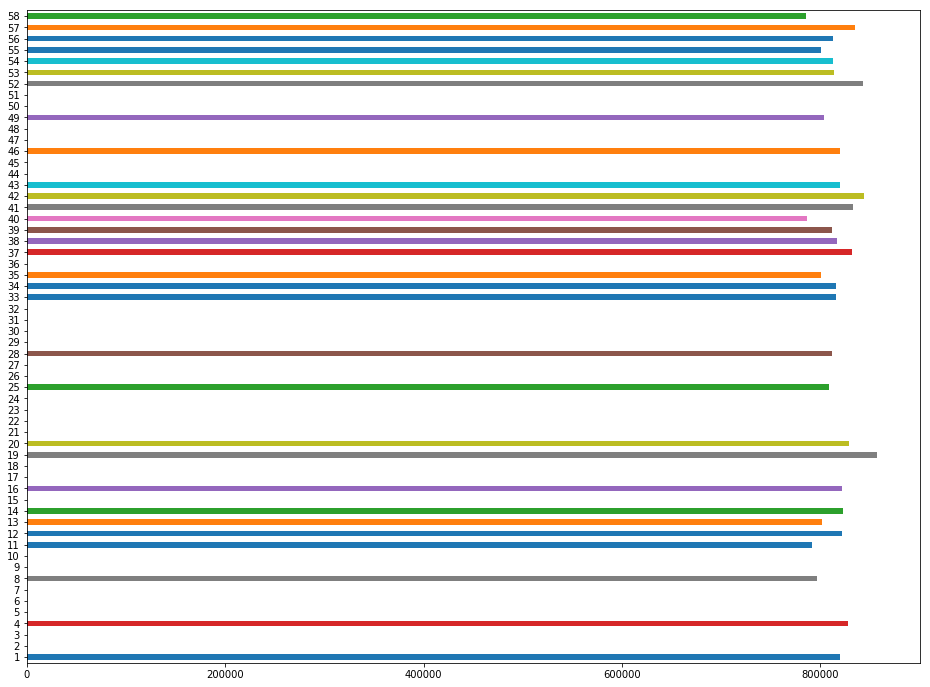

In [10]:
nunique_x = X.nunique()
axes = nunique_x.plot(kind='barh', figsize=(16, 12))

Гипотеза подтвердилась, наши признаки разделились на 2 группы: в одной у каждого параметра уникальных значений много, около 800000, в другой же их экстремально мало, по сравнению с первой группой. По графику мы можем их четко разделить по середине, поэтому проделаем это.

In [11]:
num_cat_mask = nunique_x > 400000
num_cols = nunique_x[num_cat_mask].keys().tolist()
cat_cols = nunique_x[~num_cat_mask].keys().tolist()

Посмотрим распределения числовых признаков.

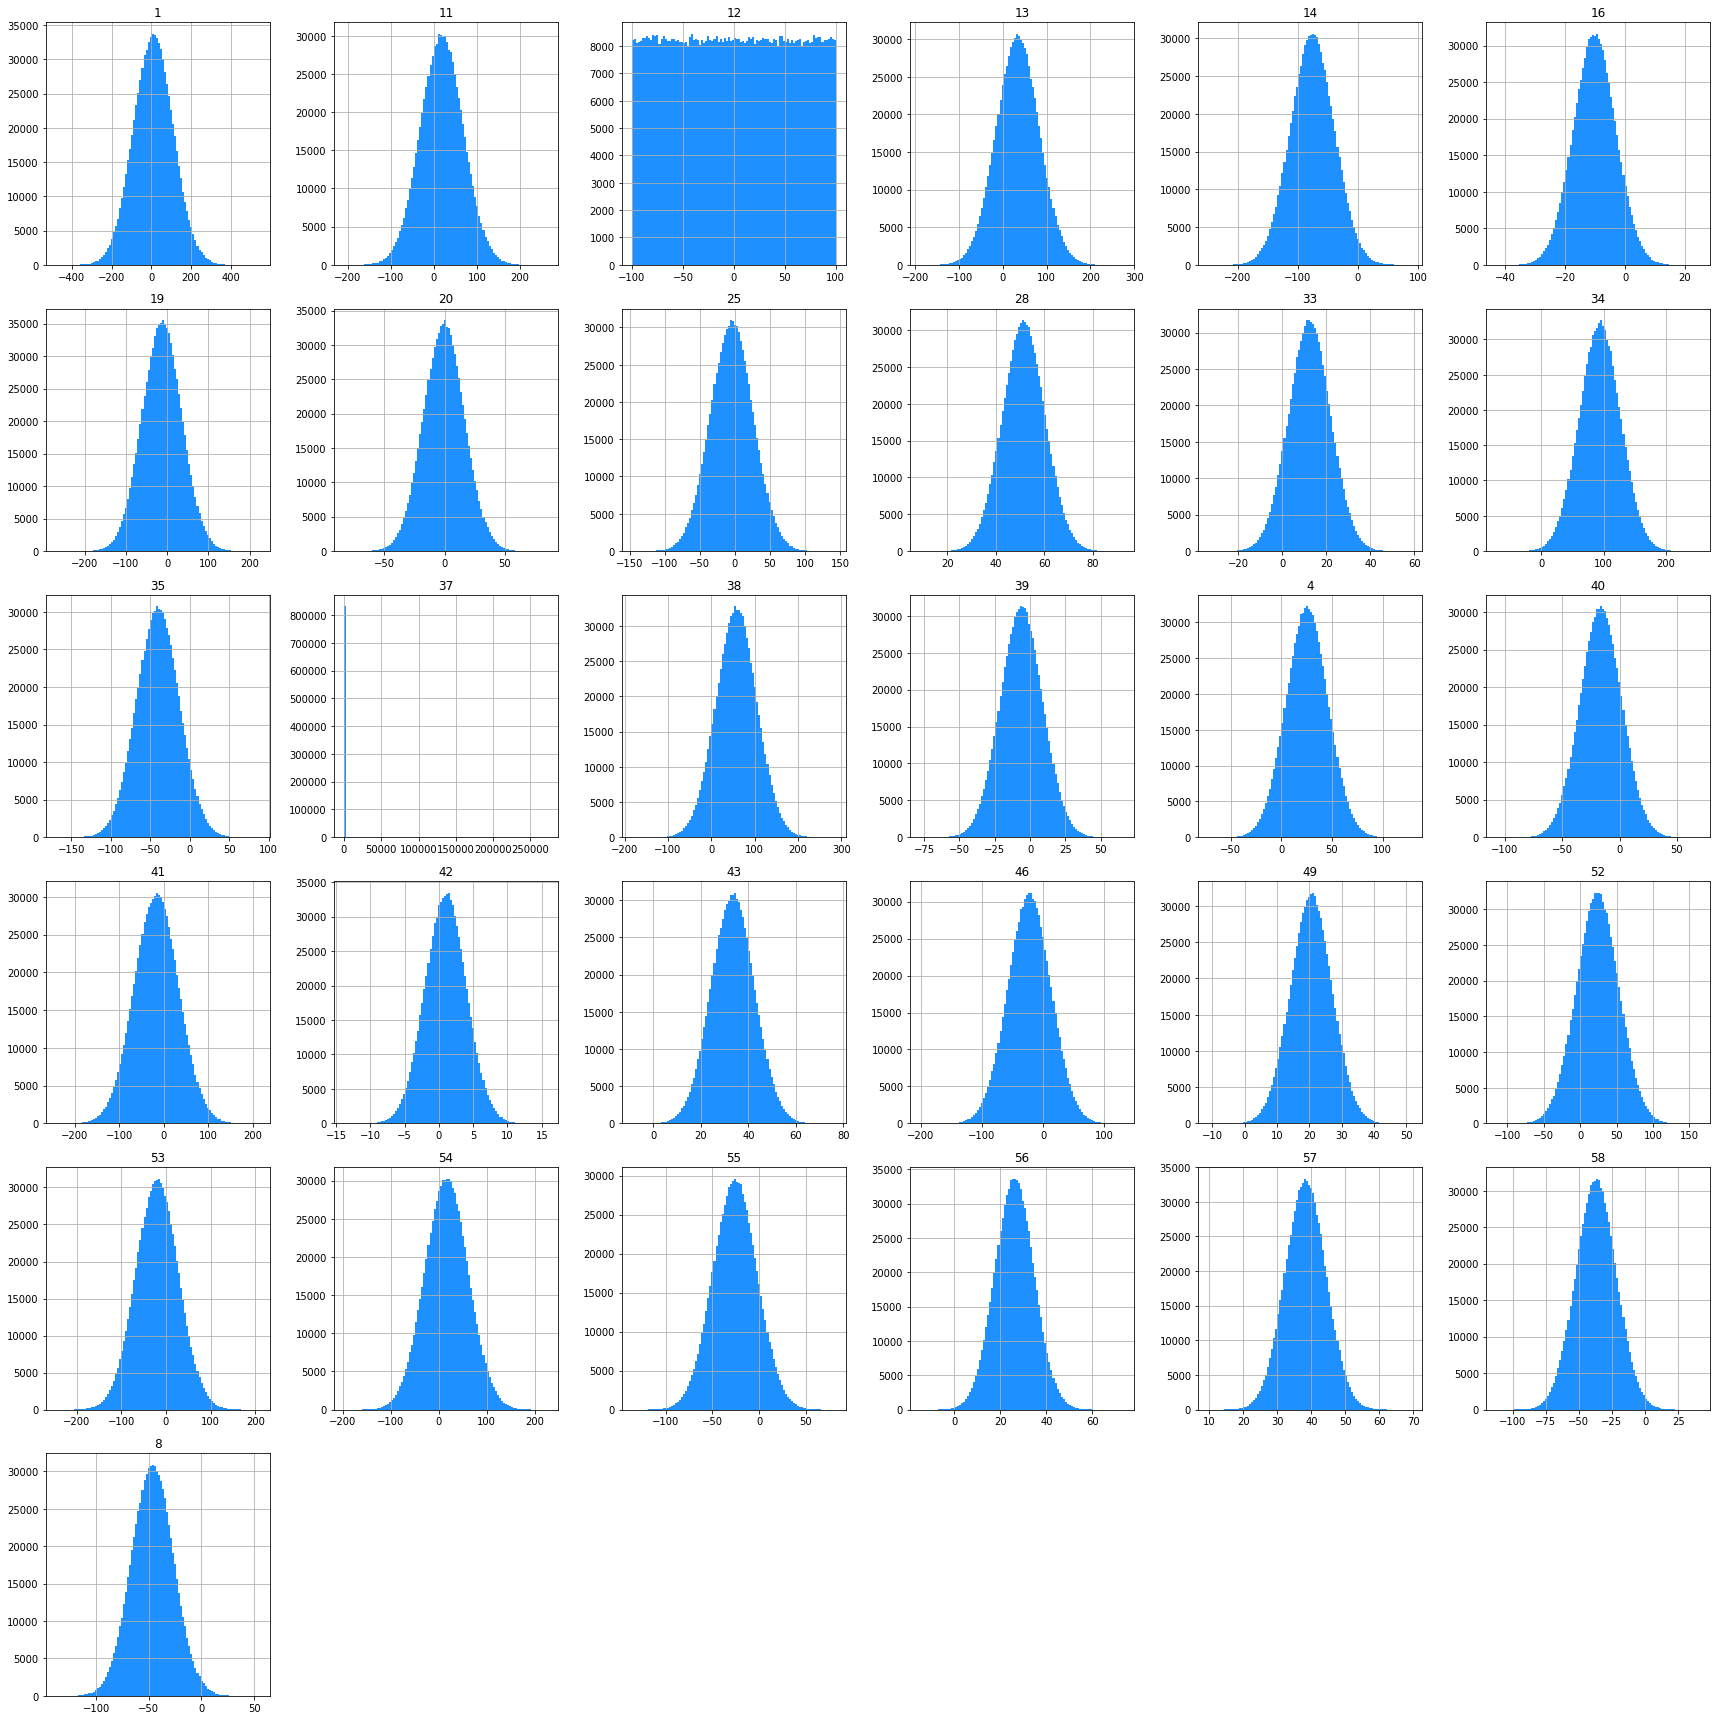

In [12]:
nrows, ncols = 8, 4
figsize = (nrows * 3, ncols * 6)
axes = X[num_cols].hist(figsize=figsize, bins=100, color='dodgerblue')
plt.tight_layout()

Красота-то какая, почти все признаки нормально распределены. И даже больше, их распределения очень схожи, пиковых значений примерной одинаковое значение, значит тут можно ~~и нужно~~(не всегда) применить PCA. Но признаки `12` и `37` выбиваются из общей нормальной массы, рассмотрим их подробнее. 

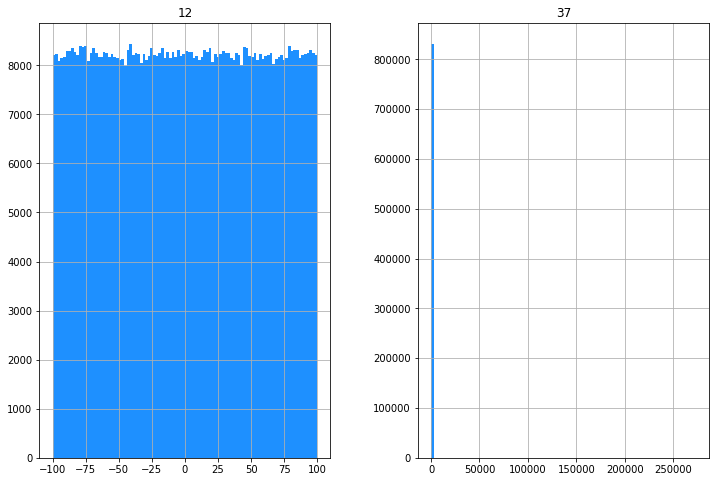

In [13]:
axes = X[['12', '37']].hist(figsize=(12, 8), bins=100, color='dodgerblue')

Видно, что `12` признак распределен более менее равномерно, а вот `37` нет. Более того, у `37` подавляющее большинство значений лежит около 0. 
Делаем вывод, что к `12` мы можем применить любой Scaler, а вот к `37` кроме StandarScaler ничего не подойдет.

Теперь рассмотрим категориальные значения.

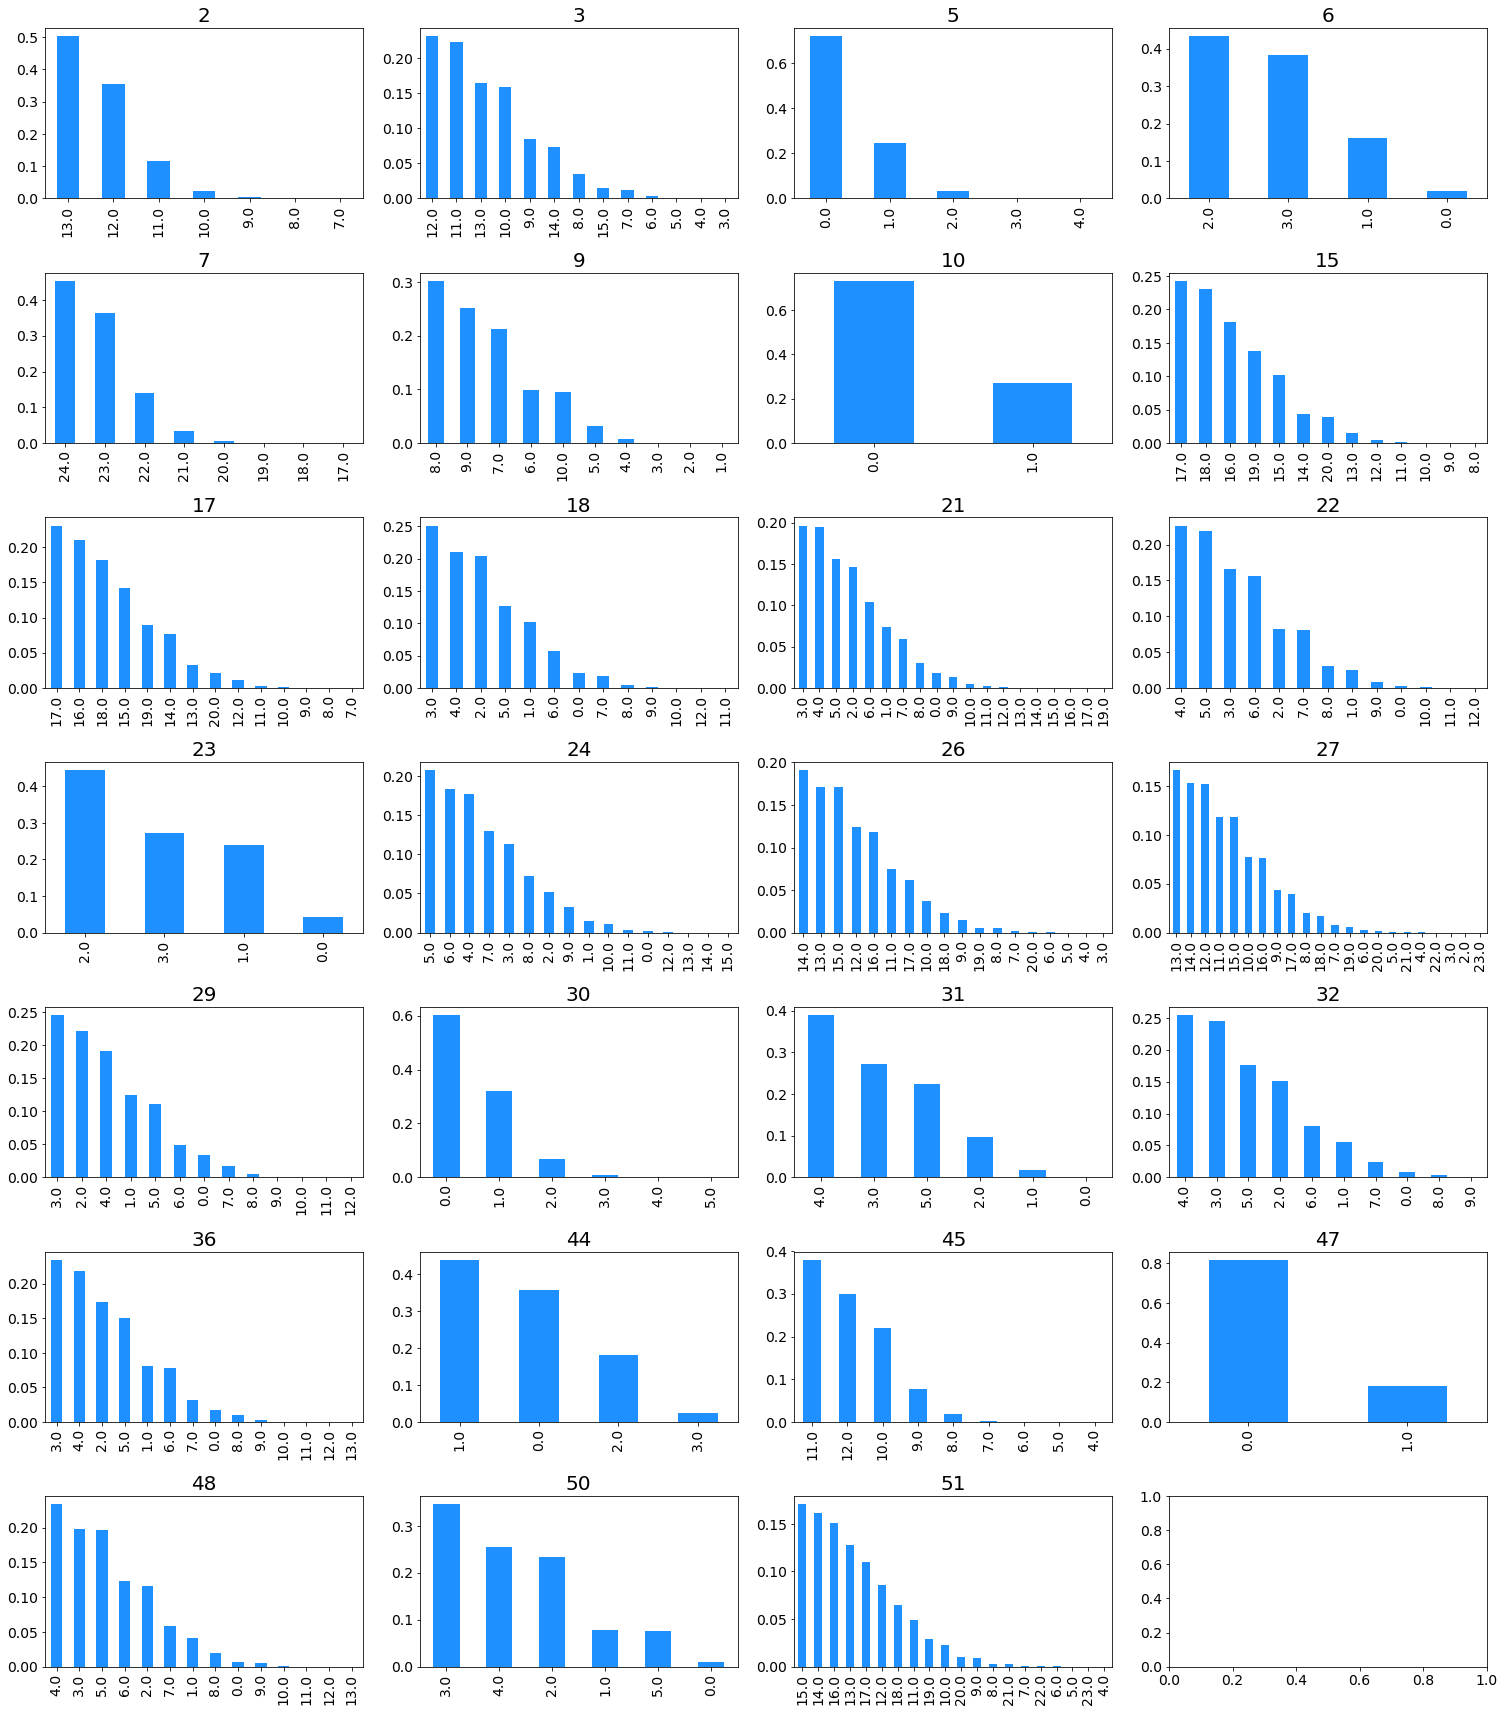

In [14]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14

nrows, ncols = 7, 4
figsize = (nrows * 3, ncols * 6)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

for i in range(len(cat_cols)):
    ax = axes[i//4, i%4]
    col = cat_cols[i]
    X[col].value_counts(normalize=True) \
          .plot(kind='bar', label=col, ax=ax, color='dodgerblue')
    ax.set_title(col)
plt.tight_layout()

А тут у нас везде что-то похожее на распределение Парето (Брэдфорда). Посмотрим на целевую пременную.

0    0.693267
1    0.306733
Name: x, dtype: float64


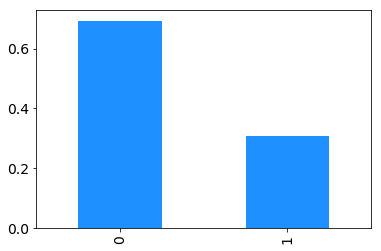

In [15]:
print(y.value_counts(normalize=True))
axes = y.value_counts(normalize=True).plot(kind='bar', color='dodgerblue')

Видим дисбаланс классов, 70:30. Это надо будет учесть, когда будем выбирать, какие алгоритмы машинного обучения применять.

Теперь построим и визуализируем матрицу корреляций. Добавим в `X` целевую переменную, чтобы увидеть, если зависимости у остальных признаков с ней.

In [17]:
X['y'] = y

In [55]:
%%time
corr_mat = X.corr()

CPU times: user 9.22 s, sys: 96 ms, total: 9.32 s
Wall time: 9.32 s


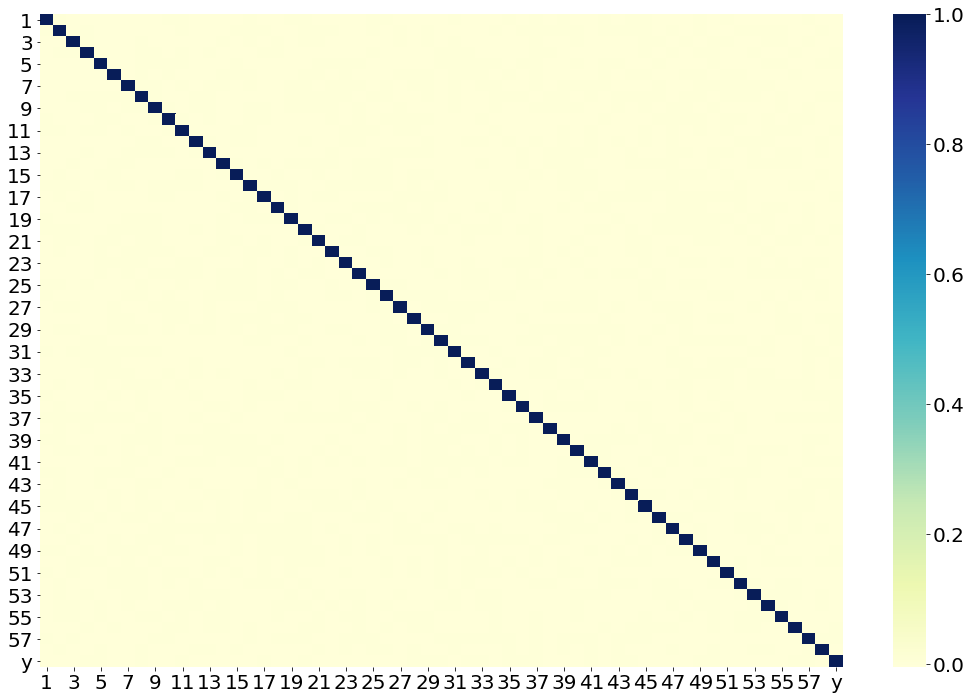

In [56]:
plt.figure(figsize=(18, 12))
axes = sns.heatmap(corr_mat, cmap="YlGnBu")

Увы, сплошное ничего. Может попробуем другой метод в `df.corr`?

CPU times: user 3min 35s, sys: 11.1 s, total: 3min 47s
Wall time: 3min 46s


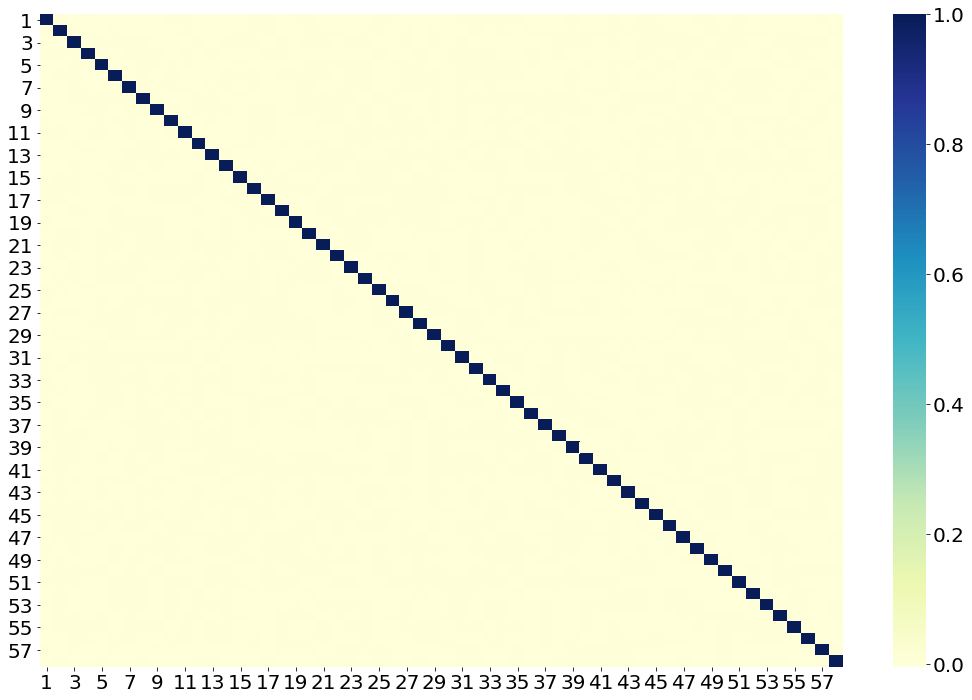

In [53]:
%%time
corr_mat = X.corr(method='spearman')
plt.figure(figsize=(18, 12))
axes = sns.heatmap(corr_mat, cmap="YlGnBu")

Не стоило, опять все около 0, но времени ушло гораздо, гораздо больше. С `method='kendall'` тоже самое :(

Теперь посмотрим, как распределены признаки относительно целевого. Начнем c численных признаков.

CPU times: user 1min 59s, sys: 11.1 s, total: 2min 10s
Wall time: 2min 4s


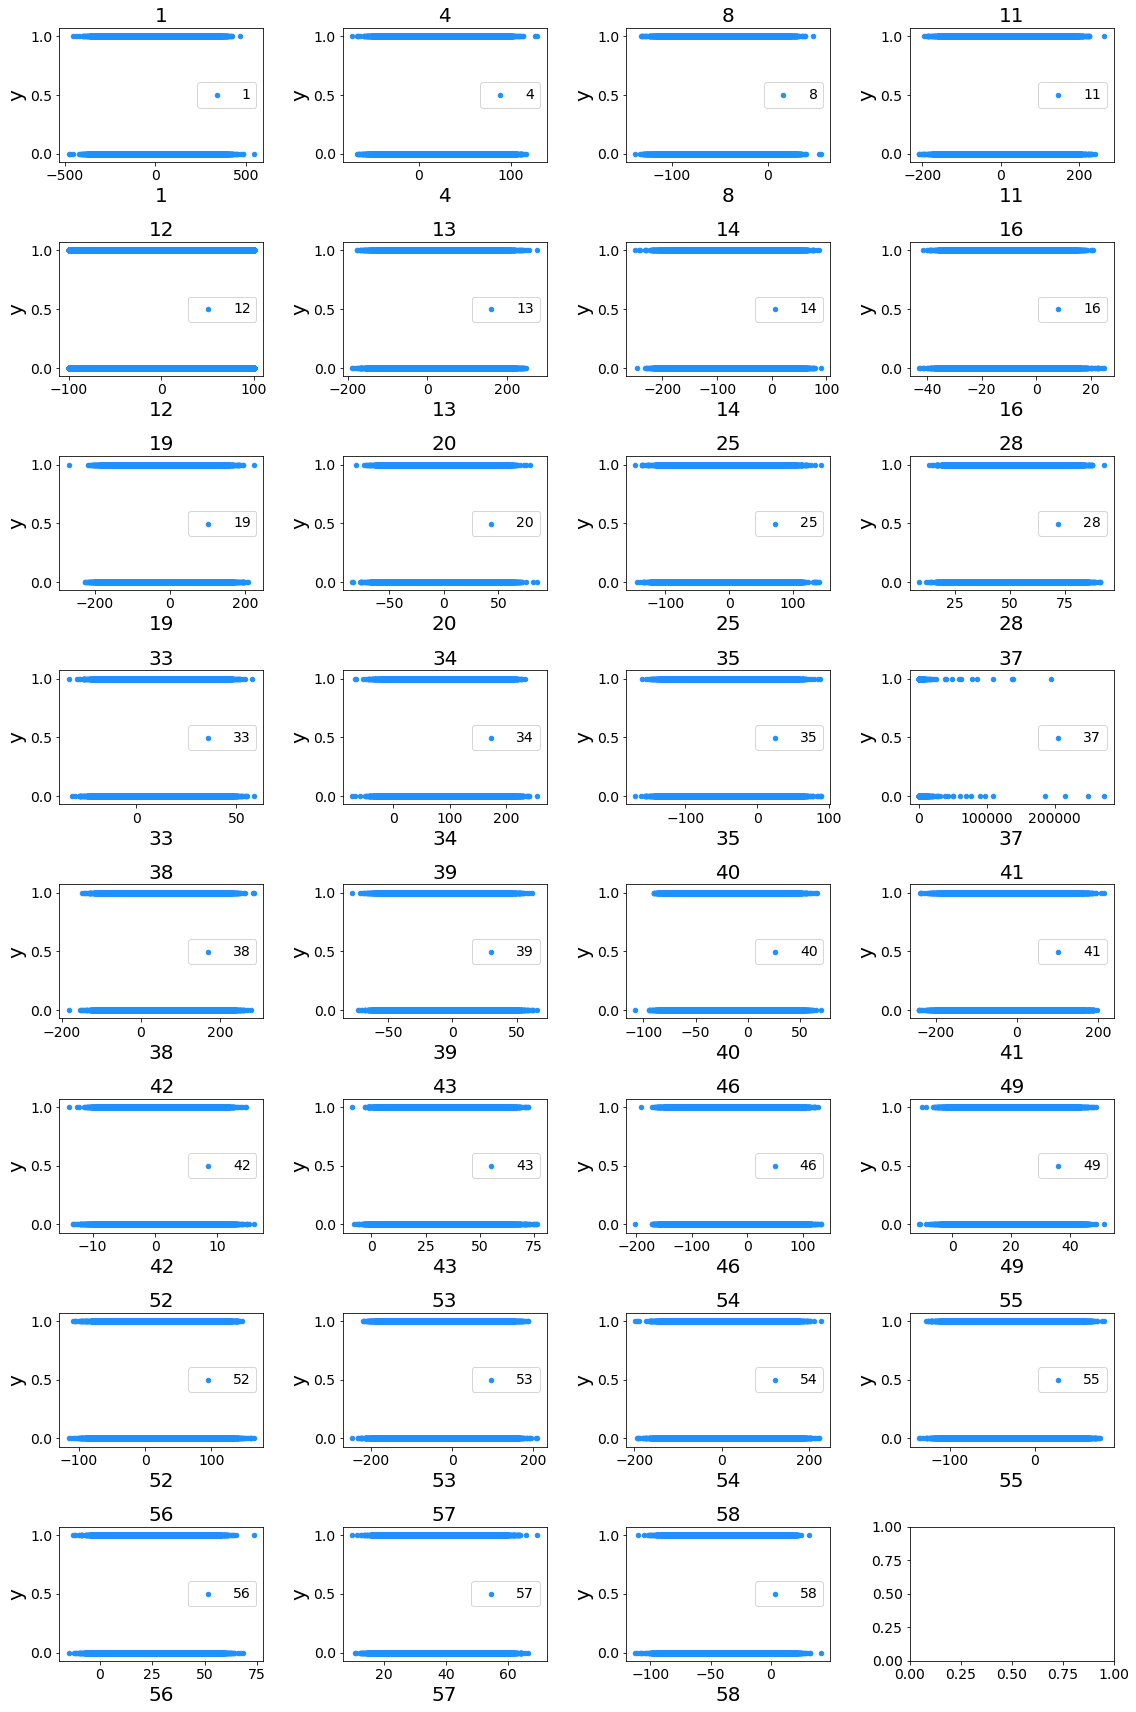

In [18]:
%%time
nrows, ncols = 8, 4
figsize = (nrows * 2, ncols * 6)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

for i in range(len(num_cols)):
    ax = axes[i//4, i%4]
    col = num_cols[i]
    X.plot(x=col, y='y', kind='scatter', label=col, ax=ax, color='dodgerblue')
    ax.set_title(col)
plt.tight_layout()

Никаких зависимостей не видно, зато есть точки-кандидаты на метку "выброс". Но их кол-во незначительно, поэтому пока оставим их в покое.

Теперь тоже самое для категориальных.

CPU times: user 3.62 s, sys: 316 ms, total: 3.93 s
Wall time: 3.51 s


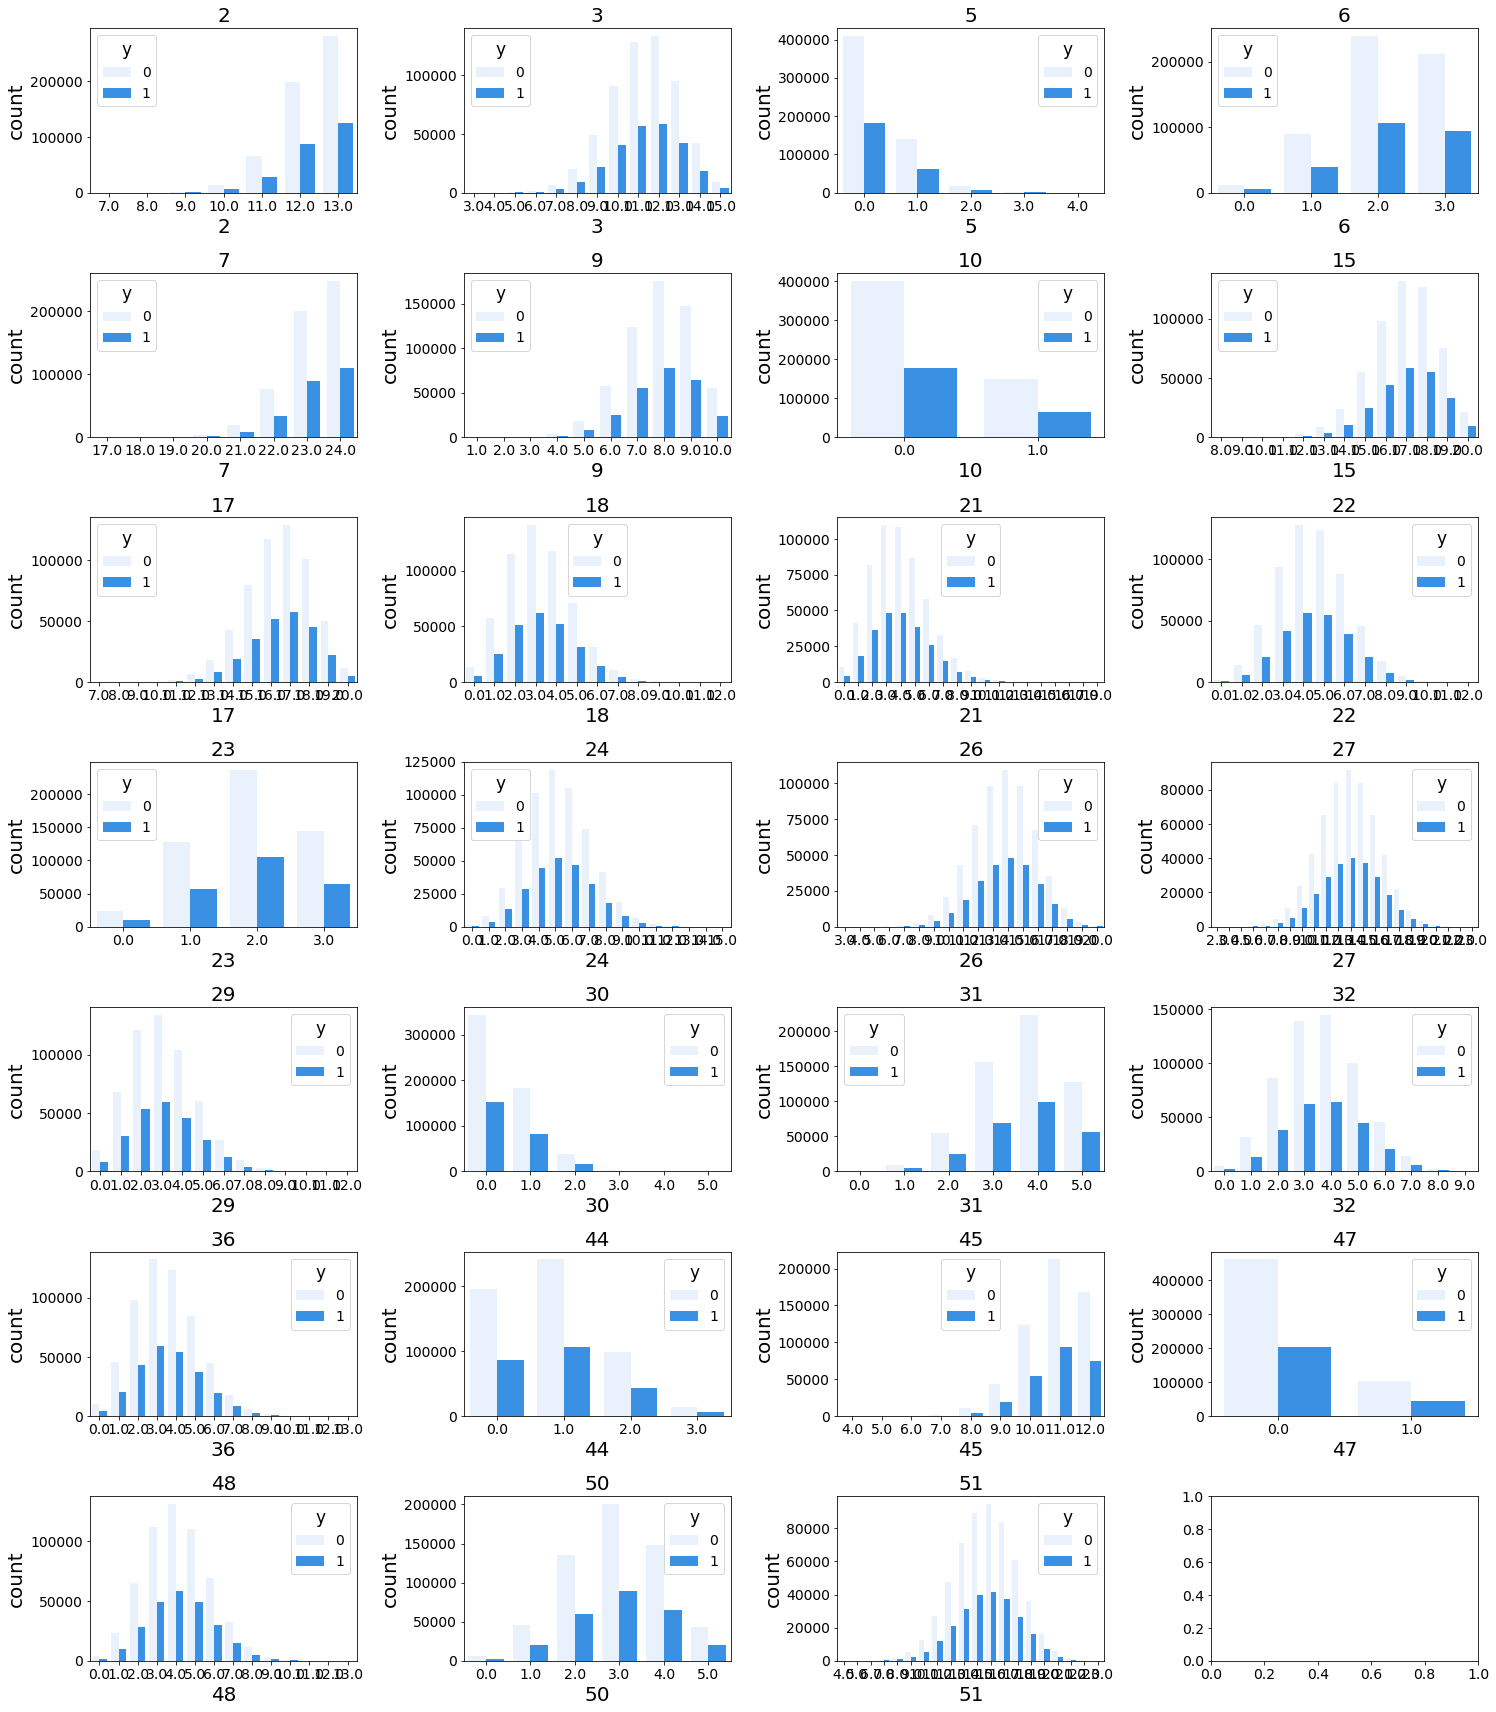

In [20]:
%%time
nrows, ncols = 7, 4
figsize = (nrows * 3, ncols * 6)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

for i in range(len(cat_cols)):
    ax = axes[i//4, i%4]
    col = cat_cols[i]
    sns.countplot(x=col, hue='y', data=X, ax=ax, color='dodgerblue')
    ax.set_title(col)
plt.tight_layout()

И тут пустота, на взгляд никаких корреляций. Попробуем посмотреть через долю позитивного класса.

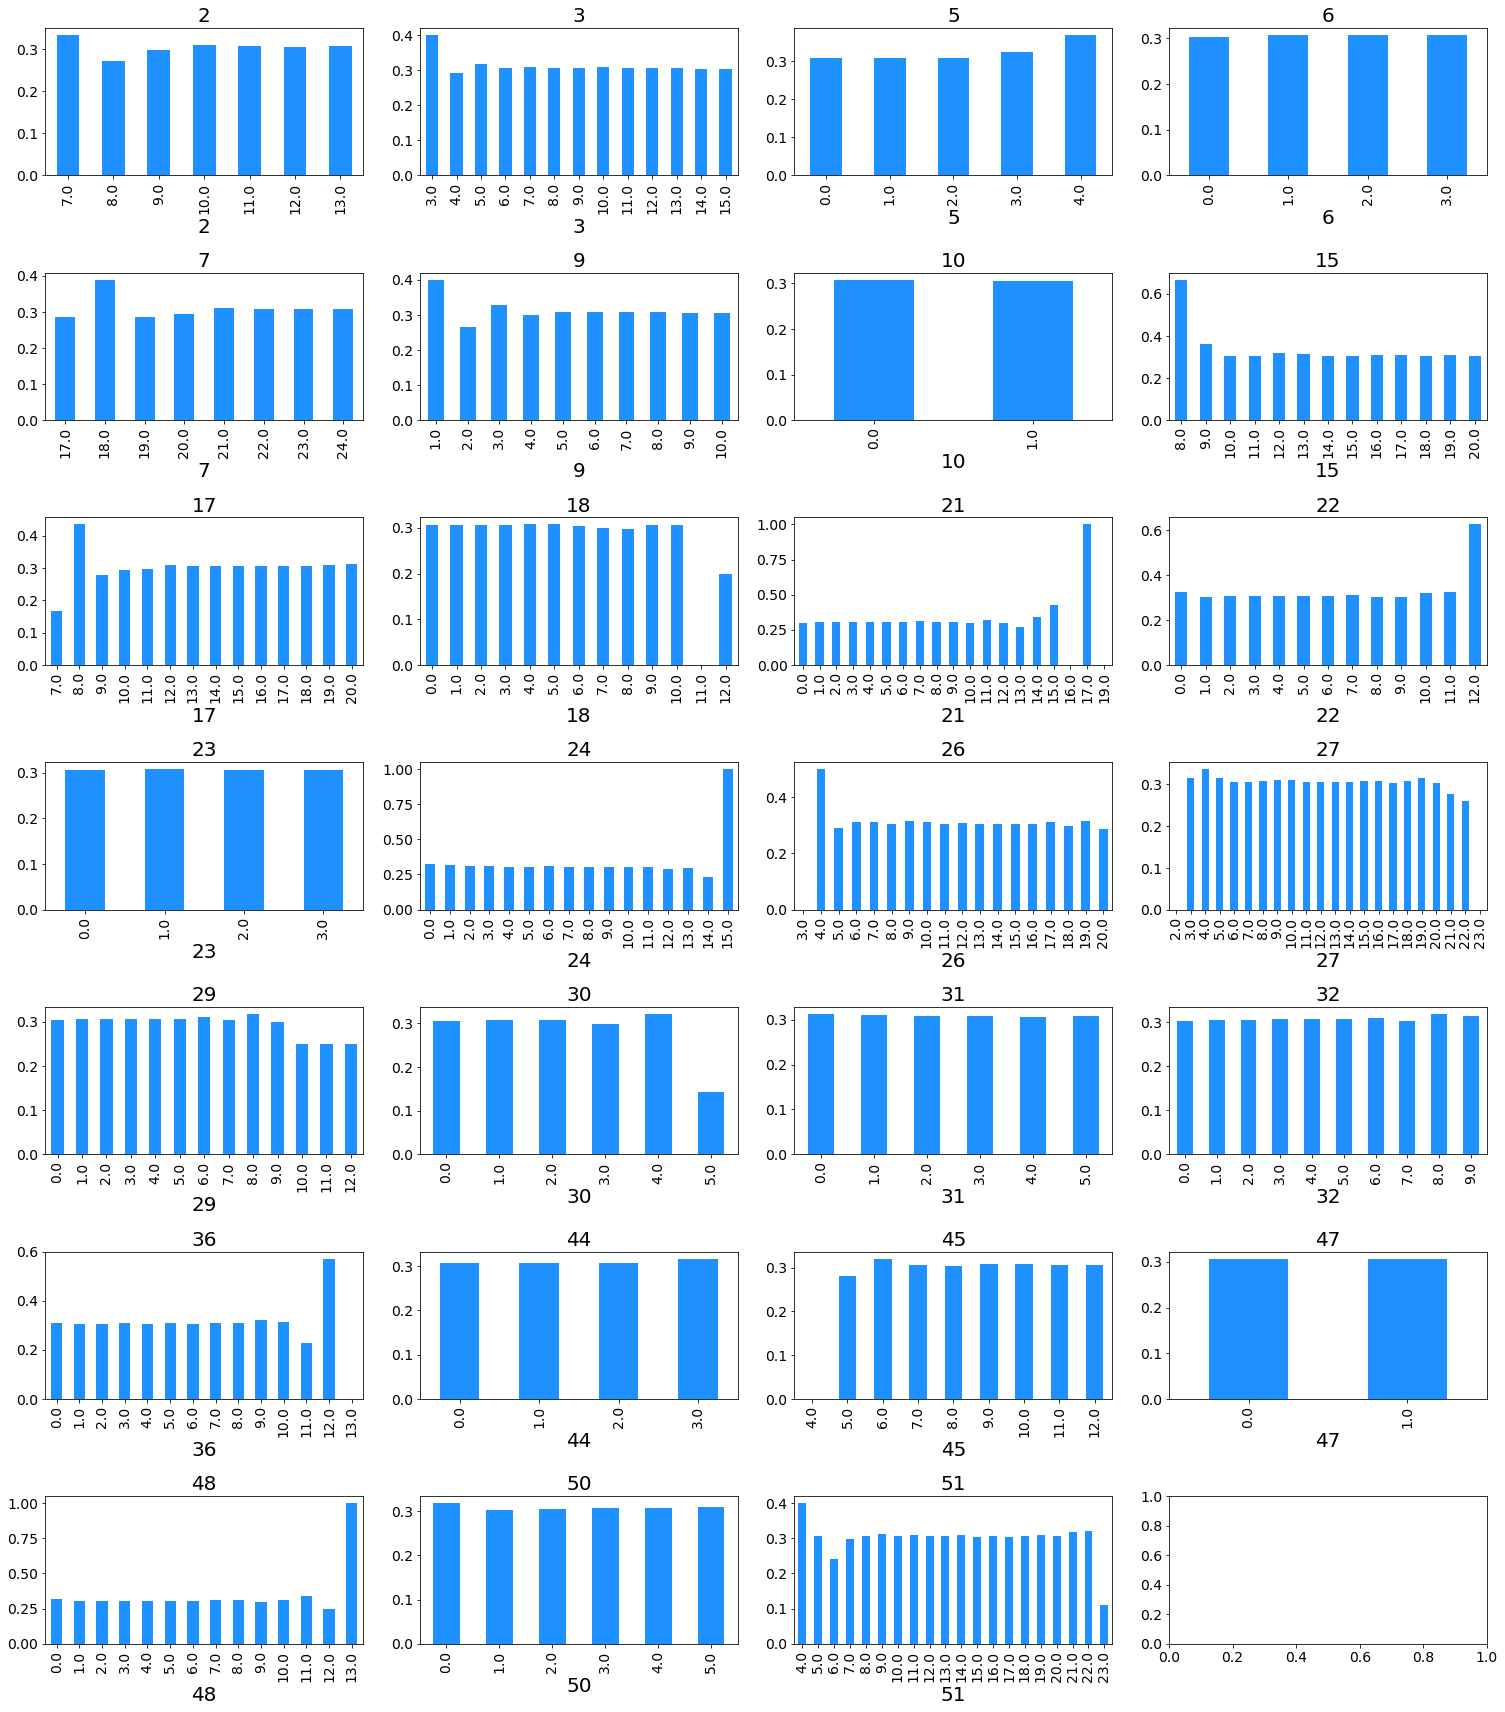

In [21]:
nrows, ncols = 7, 4
figsize = (nrows * 3, ncols * 6)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

for i in range(len(cat_cols)):
    ax = axes[i//4, i%4]
    col = cat_cols[i]
    X.groupby(col)['y'].mean().plot(kind='bar', ax=ax, color='dodgerblue')
    ax.set_title(col)

plt.tight_layout()

А тут уже интересней. Половина признаков почти не несет никакой информации о целевом классе, но у некоторых признаков есть значение, которое прямо сигнализирует о принадлежности объекта к целевому классу. Здесь должны хорошо отработать OHE и TargetEncoding.

## 4. Инсайты

Сложно говорить о каких-то инсайтах с анонимными фичами, но все же:
1. Большинство численных значений распределены нормально, значит PCA с ними должно отработать очень хорошо.
2. Корреляций нет, а датасет не маленький, значит можно спокойно пробовать различные линейные модели.
3. Среди категорильных признаков есть те, у которых есть "сильные" значения (`X['48']==13.0` почти у всех объектов с `X['y']==1`) , т.е. которые хорошо описывают целевой класс.

## 5. Выбор метрики

Основной метрикой для оценки качества модели будет ROC-AUC. Она хорошо справляется с несбалансированными классами. Но также не стоит забывать, что мы делаем алгоритм для систем нахождения неполадок и здесь ошибки первого (FalsePositive) и  второго рода (FalseNegative) не раноправны . Ведь затраты на лишнюю проверку обычно ниже, чем убыток от вовремя несработавшей системы. Исходя из этого, надо также внимательно следить за метрикой Recall.

Итого:
- ROC_AUC
- Recall

## 6. Выбор модели

В данном датасете есть как числовые, так и категориальные признаки, поэтому градиентный бустинг - наш выбор. Они показывают хорошие результаты на данных такого типа и в тоже время интерпретируемы. Но это тяжеловесные методы, не будем забывать о старой доброй логистической регрессии и случайном лесе, возможно выигрыш по времени будет гораздо значительней, чем по точности.

Итого:
- LogisticRegression
- RandomForestClassifier
- XGBoost
- LightGBM

## 7. Предобработка данных

Настало время вспомнить о том, что у нас очень много `NaN`. Поступим с ними так: в числовых признаках заменим пустые значения средним, а в категориальных - медианой.

In [25]:
for col in num_cols:
    X[col] = X[col].fillna(X[col].mean())
    
for col in cat_cols:
    X[col] = X[col].fillna(X[col].median())

In [27]:
print("Count of NaN's in X - {}".format(X.isnull().sum().sum()))

0

Прежде чем приступать к обучению моделей, попробуем снизить размерность, датасет не маленький ведь. Для этого обучим логистическую регрессию, но не из `scikit-learn`, а из `statsmodel`. Это делаем для того, чтобы получить более подробный отчет о значимости признаков. Но больше всего там нас будет интересовать 2 вещи:
- Pseudo R squared - один из самых важных индикаторов контроля качества модели
- P-value по каждому признаку как мера важности признака

In [49]:
model = sm.Logit(y.values, X.drop(columns='y'))
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.616462
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               900000
Model:                          Logit   Df Residuals:                   899942
Method:                           MLE   Df Model:                           57
Date:                Sun, 22 Apr 2018   Pseudo R-squ.:               3.530e-08
Time:                        20:32:53   Log-Likelihood:            -5.5482e+05
converged:                       True   LL-Null:                   -5.5482e+05
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1          -4.949e-06   2.39e-05     -0.207      0.836   -5.19e-05     4.2e-05
2             -0.0087      0.

Видно, что `Pseudo R-squ.` очень и очень мал, что означает наша модель не лучше, чем просто предсказывать среднее значение. Попробуем теперь взять только те значение, у которых p-value (`P>|z|`) меньше или равна 10%.

In [54]:
sig_columns = [i for i,x in enumerate(result.pvalues.ravel()) if x<=0.1]

model = sm.Logit(y, X.iloc[:,sig_columns])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.616479
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      x   No. Observations:               900000
Model:                          Logit   Df Residuals:                   899989
Method:                           MLE   Df Model:                           10
Date:                Sun, 22 Apr 2018   Pseudo R-squ.:              -2.840e-05
Time:                        20:37:44   Log-Likelihood:            -5.5483e+05
converged:                       True   LL-Null:                   -5.5482e+05
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
2             -0.0090      0.003     -3.373      0.001      -0.014      -0.004
3             -0.0045      0.

Мда, мы сократили кол-во признаков до 11, но получили негативный `Pseudo R-squ.`. Это означает, что наша модель теперь хуже, чем просто предсказывать среднее значение. Тоже само будет, если мы ограничем p-value 1 процентом.

Теперь займемся обработкой. Числовые признаки обработаем с помощью `StandardScaler`.

In [30]:
scaler = StandardScaler()
scaler.fit(X[num_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [31]:
#X_nums = scaler.transform(X[num_cols])
X[num_cols] = scaler.transform(X[num_cols])

CPU times: user 200 ms, sys: 92 ms, total: 292 ms
Wall time: 290 ms


Категориальные признаки обработаем с помощью `OneHotEncoder` и `TargetEncoder`.

In [32]:
cat_union = FeatureUnion([
    ('ohe', ce.OneHotEncoder()),
    ('target', ce.TargetEncoder())
], n_jobs=-1)
cat_union.fit(X[cat_cols], y)

CPU times: user 940 ms, sys: 744 ms, total: 1.68 s
Wall time: 1.88 s


In [40]:
X_cats = cat_union.transform(X[cat_cols])
print(X_cats.shape)

(900000, 54)


Теперь объединим обработанные данные с помощью `np.hstack`

In [39]:
X_train = np.hstack((X_nums, X_cats))
print(X_train.shape)

(900000, 85)


## 8. Кросс-валидация и настройка гиперпараметров

## 9. Создание новых признаков и описание этого процесса

## 10. Построение кривых валидации и обучения

## 11. Прогноз для тестовой или отложенной выборке

## 12. Выводы